### 1. Loading the Datasets
Training: Code Red 559 10 Min + Nimda 559 10 Min 

Test: Slammer 559 10 Min

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, 
    precision_recall_fscore_support, roc_curve, auc, 
    precision_recall_curve, average_precision_score
)
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import joblib
import warnings

# Import explainability libraries if installed
try:
    import shap
    import lime
    import lime.lime_tabular
    EXPLAINABILITY_AVAILABLE = True
except ImportError:
    EXPLAINABILITY_AVAILABLE = False
    print("Warning: SHAP and/or LIME libraries not installed. Explainability sections will be skipped.")
    print("Run 'pip install shap lime' to install them.")

# Suppress warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

In [2]:
# Load the first training dataset - update the path to the dataset file you want to use
dataset_path = "../../datasets/dataset_nimda_559_10_rrc04.csv"
df = pd.read_csv(dataset_path)

# Check the first few rows
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (1056, 52)


,Unnamed: 0,ann_to_longer,ann_to_shorter,announcements,as_path_avg,as_path_max,class,dups,edit_distance_avg,edit_distance_dict_0,...,origin_2,origin_changes,rare_ases_avg,rare_ases_max,timestamp,timestamp2,unique_as_path_avg,unique_as_path_max,wd_dups,withdrawals
0,0,75,53,268,6,17,0,60,1.807175,72,...,27,3,0.0,0,2001-09-15 20:13:25,1000584805,6,13,0,57
1,1,24,33,526,6,16,0,11,1.442529,215,...,16,0,0.0,0,2001-09-15 20:23:25,1000585405,6,10,0,196
2,2,65,53,167,5,14,0,24,2.467532,33,...,10,0,0.0,0,2001-09-15 20:33:25,1000586005,5,11,0,23
3,3,15,17,76,3,14,0,10,2.130435,27,...,4,1,0.0,0,2001-09-15 20:43:25,1000586605,3,7,0,20
4,4,36,32,212,7,15,0,20,1.185714,116,...,6,0,0.0,0,2001-09-15 20:53:25,1000587205,6,8,0,28


In [3]:
# Load the second training dataset - update the path to the dataset file you want to use
dataset_path = "../../datasets/dataset_code-red_559_10_rrc04.csv"
df_2 = pd.read_csv(dataset_path)

# Check the first few rows
print(f"Dataset shape: {df_2.shape}")
df_2.head()

Dataset shape: (736, 52)


,Unnamed: 0,ann_to_longer,ann_to_shorter,announcements,as_path_avg,as_path_max,class,dups,edit_distance_avg,edit_distance_dict_0,...,origin_2,origin_changes,rare_ases_avg,rare_ases_max,timestamp,timestamp2,unique_as_path_avg,unique_as_path_max,wd_dups,withdrawals
0,0,63,157,352,4,17,0,58,1.997050,102,...,41,18,0.000000,0,2001-07-17 00:50:50,995331050,4,14,0,57
1,1,60,35,355,4,12,0,87,1.422741,149,...,16,0,0.000000,0,2001-07-17 01:00:50,995331650,4,12,0,59
2,2,54,38,397,4,11,0,43,1.798469,61,...,32,4,0.104762,4,2001-07-17 01:10:50,995332250,4,9,0,35
3,3,67,51,274,4,10,0,39,1.966292,71,...,34,0,0.113139,3,2001-07-17 01:20:50,995332850,4,9,0,44
4,4,167,163,419,4,11,0,47,1.861985,73,...,24,1,0.062053,4,2001-07-17 01:30:50,995333450,4,9,0,40


In [4]:
# Combine the training data
df = pd.concat([df, df_2])
print(f"Dataset shape: {df.shape}")

Dataset shape: (1792, 52)


### 2. Data Exploration and Preprocessing

In [5]:
# Check basic statistics
df.describe()

,Unnamed: 0,ann_to_longer,ann_to_shorter,announcements,as_path_avg,as_path_max,class,dups,edit_distance_avg,edit_distance_dict_0,...,origin_1,origin_2,origin_changes,rare_ases_avg,rare_ases_max,timestamp2,unique_as_path_avg,unique_as_path_max,wd_dups,withdrawals
count,1792.000000,1792.000000,1792.000000,1792.000000,1792.000000,1792.000000,1792.000000,1792.000000,1792.000000,1792.000000,...,1792.000000,1792.000000,1792.000000,1792.000000,1792.000000,1.792000e+03,1792.000000,1792.000000,1792.000000,1792.000000
mean,461.785714,90.954241,85.403460,397.242746,6.047991,14.075335,0.223772,57.164621,1.844427,142.035714,...,0.194754,22.716518,1.845424,0.016058,1.010045,9.987039e+08,5.526786,9.695312,0.008929,109.157366
std,282.031125,120.282104,100.203599,1053.563389,2.087943,3.052018,0.416888,601.014336,0.557642,829.238058,...,1.181712,26.100694,5.018235,0.021759,0.872631,2.637644e+06,1.414355,1.438802,0.311565,933.290083
min,0.000000,0.000000,1.000000,8.000000,1.000000,7.000000,0.000000,0.000000,0.038501,7.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,9.953310e+08,1.000000,7.000000,0.000000,1.000000
25%,223.750000,34.000000,33.750000,156.000000,5.000000,12.000000,0.000000,13.000000,1.508238,47.000000,...,0.000000,12.000000,0.000000,0.000000,0.000000,9.955997e+08,5.000000,9.000000,0.000000,30.000000
50%,447.500000,61.000000,59.000000,260.000000,6.000000,14.000000,0.000000,23.000000,1.824786,78.000000,...,0.000000,19.000000,1.000000,0.008460,1.000000,1.000681e+09,6.000000,9.000000,0.000000,52.000000
75%,671.250000,105.000000,98.000000,420.250000,7.000000,16.000000,0.000000,44.000000,2.132701,136.000000,...,0.000000,27.000000,2.000000,0.023440,2.000000,1.000949e+09,6.000000,11.000000,0.000000,98.000000
max,1055.000000,2613.000000,1650.000000,27607.000000,17.000000,31.000000,1.000000,25288.000000,5.182529,27286.000000,...,33.000000,696.000000,92.000000,0.184615,7.000000,1.001204e+09,13.000000,15.000000,13.000000,35850.000000


In [6]:
# Check for missing values
print("Missing values in each column:")
df.isnull().sum()

Missing values in each column:


Unnamed: 0                      0
ann_to_longer                   0
ann_to_shorter                  0
announcements                   0
as_path_avg                     0
as_path_max                     0
class                           0
dups                            0
edit_distance_avg               0
edit_distance_dict_0            0
edit_distance_dict_1            0
edit_distance_dict_10           0
edit_distance_dict_2            0
edit_distance_dict_3            0
edit_distance_dict_4            0
edit_distance_dict_5            0
edit_distance_dict_6            0
edit_distance_dict_7            0
edit_distance_dict_8            0
edit_distance_dict_9            0
edit_distance_max               0
edit_distance_unique_dict_0     0
edit_distance_unique_dict_1     0
edit_distance_unique_dict_10    0
edit_distance_unique_dict_2     0
edit_distance_unique_dict_3     0
edit_distance_unique_dict_4     0
edit_distance_unique_dict_5     0
edit_distance_unique_dict_6     0
edit_distance_

In [7]:
# Fill missing values with 0 (if any)
df = df.fillna(0)

Class distribution:
class
0    1391
1     401
Name: count, dtype: int64


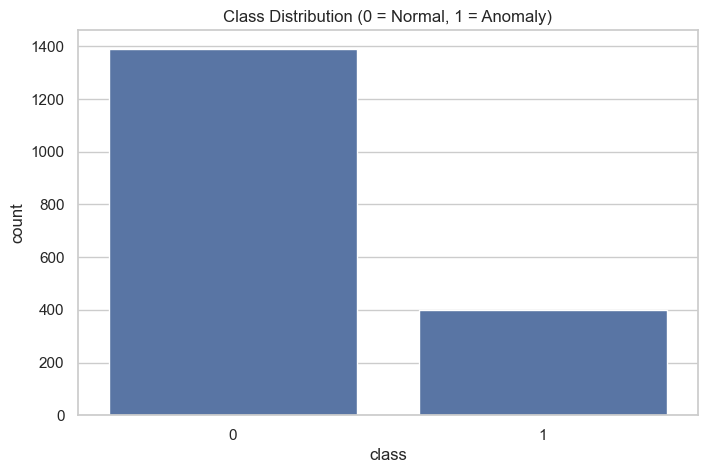

In [8]:
# Check class distribution
print("Class distribution:")
print(df['class'].value_counts())

# Plot class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='class', data=df)
plt.title('Class Distribution (0 = Normal, 1 = Anomaly)')
plt.show()

In [9]:
# Drop non-feature columns
columns_to_drop = ['timestamp', 'timestamp2', 'Unnamed: 0']
for col in columns_to_drop:
    if col in df.columns:
        df = df.drop(col, axis=1)

# Separate features and target
X = df.drop('class', axis=1)
y = df['class']

# Display feature names
print(f"Number of features: {X.shape[1]}")
print("Feature names:")
X.columns.tolist()

Number of features: 48
Feature names:


['ann_to_longer',
 'ann_to_shorter',
 'announcements',
 'as_path_avg',
 'as_path_max',
 'dups',
 'edit_distance_avg',
 'edit_distance_dict_0',
 'edit_distance_dict_1',
 'edit_distance_dict_10',
 'edit_distance_dict_2',
 'edit_distance_dict_3',
 'edit_distance_dict_4',
 'edit_distance_dict_5',
 'edit_distance_dict_6',
 'edit_distance_dict_7',
 'edit_distance_dict_8',
 'edit_distance_dict_9',
 'edit_distance_max',
 'edit_distance_unique_dict_0',
 'edit_distance_unique_dict_1',
 'edit_distance_unique_dict_10',
 'edit_distance_unique_dict_2',
 'edit_distance_unique_dict_3',
 'edit_distance_unique_dict_4',
 'edit_distance_unique_dict_5',
 'edit_distance_unique_dict_6',
 'edit_distance_unique_dict_7',
 'edit_distance_unique_dict_8',
 'edit_distance_unique_dict_9',
 'flaps',
 'imp_wd',
 'imp_wd_dpath',
 'imp_wd_spath',
 'nadas',
 'news',
 'nlri_ann',
 'number_rare_ases',
 'origin_0',
 'origin_1',
 'origin_2',
 'origin_changes',
 'rare_ases_avg',
 'rare_ases_max',
 'unique_as_path_avg',
 'uniq

### 3. Feature Analysis and Selection

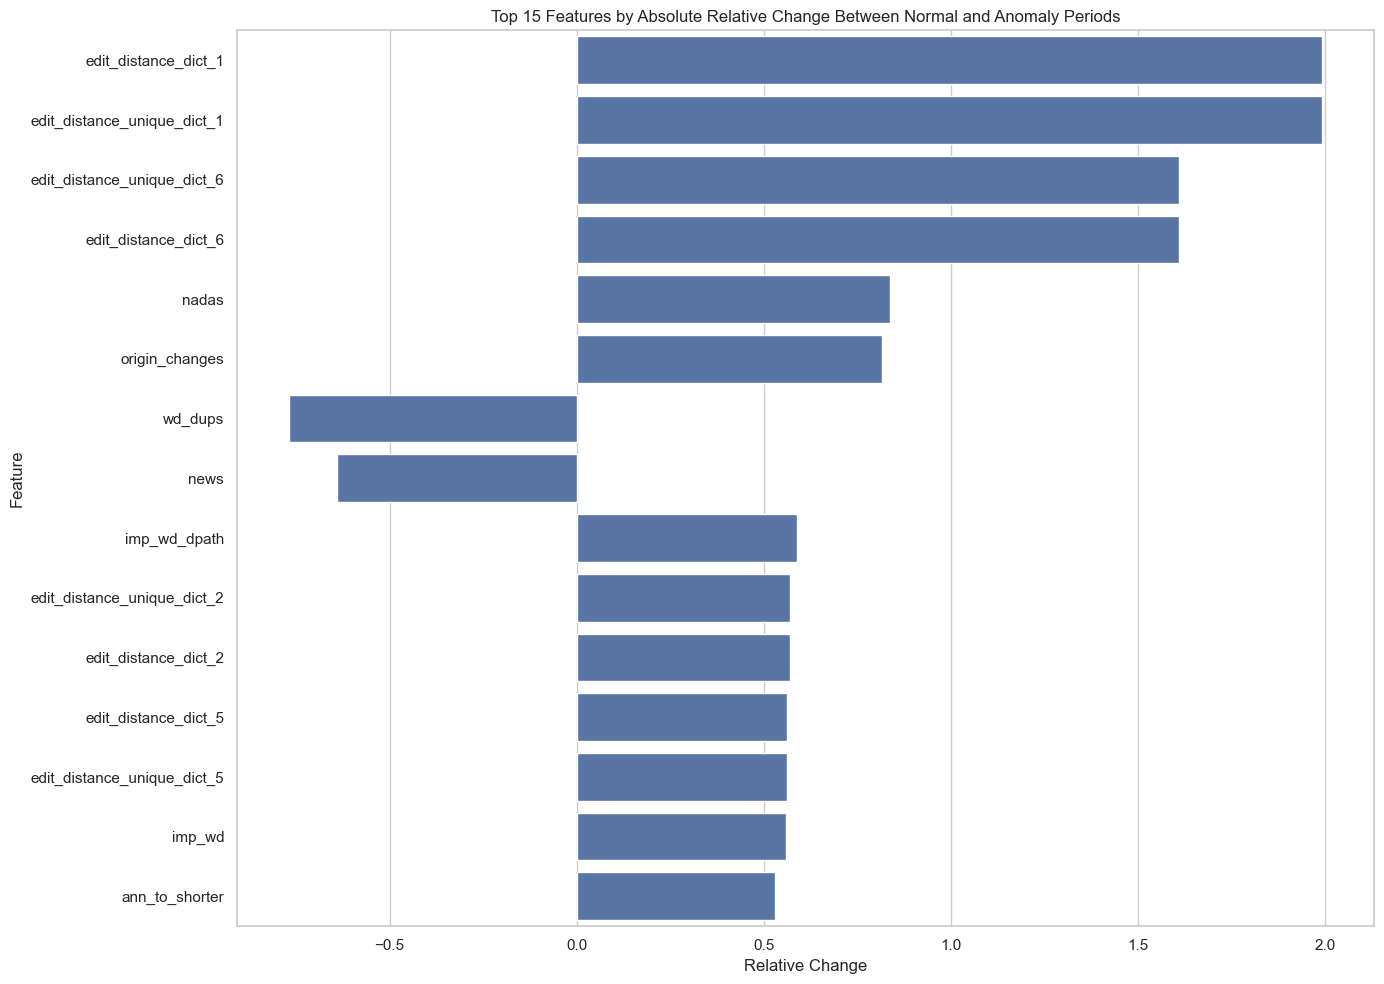

In [10]:
# Analyze feature importance for anomaly detection
# For each feature, calculate the mean difference between normal and anomaly periods
anomaly = df[df['class'] == 1]
normal = df[df['class'] == 0]

# Calculate mean differences
feature_diffs = {}
for col in X.columns:
    if col != 'class':
        normal_mean = normal[col].mean()
        anomaly_mean = anomaly[col].mean() if not anomaly.empty else 0
        
        # Prevent division by zero
        if normal_mean == 0:
            if anomaly_mean == 0:
                diff = 0
            else:
                diff = float('inf')
        else:
            diff = (anomaly_mean - normal_mean) / normal_mean
        
        feature_diffs[col] = diff

# Convert to DataFrame for better visualization
feature_diff_df = pd.DataFrame(list(feature_diffs.items()), columns=['Feature', 'Relative Change'])
feature_diff_df = feature_diff_df.sort_values('Relative Change', key=abs, ascending=False)

# Plot top features by absolute difference
plt.figure(figsize=(14, 10))
sns.barplot(x='Relative Change', y='Feature', data=feature_diff_df.head(15))
plt.title('Top 15 Features by Absolute Relative Change Between Normal and Anomaly Periods')
plt.tight_layout()
plt.show()

In [11]:
# Select top features based on difference analysis
top_features = feature_diff_df.head(15)['Feature'].tolist()
print("Selected top features:")
print(top_features)

# Extract selected features from dataset
X_selected = X[top_features]

Selected top features:
['edit_distance_dict_1', 'edit_distance_unique_dict_1', 'edit_distance_unique_dict_6', 'edit_distance_dict_6', 'nadas', 'origin_changes', 'wd_dups', 'news', 'imp_wd_dpath', 'edit_distance_unique_dict_2', 'edit_distance_dict_2', 'edit_distance_dict_5', 'edit_distance_unique_dict_5', 'imp_wd', 'ann_to_shorter']


### 4. SVM Model Training and Hyperparameter Tuning

In [12]:
# Define training and test data
y_train = df["class"]
X_train = df.drop(["class"], axis=1)

# Test data
dataset_path = "../../datasets/dataset_slammer_559_10_rrc04.csv"
df_test = pd.read_csv(dataset_path)
# Drop non-feature columns
columns_to_drop = ['timestamp', 'timestamp2', 'Unnamed: 0']
for col in columns_to_drop:
    if col in df_test.columns:
        df_test = df_test.drop(col, axis=1)
y_test = df_test["class"]
X_test = df_test.drop(["class"], axis=1)

In [13]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [14]:
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid, cross_val_score

# keep your pipeline and param_grid
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True))
])

param_grid = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': ['scale', 'auto', 0.1, 0.01],
    'svm__kernel': ['rbf', 'linear', 'poly']
}

best_score = -1
best_params = None

# wrap the list of all param‐combos in tqdm
for params in tqdm(list(ParameterGrid(param_grid)), desc="Grid search"):
    pipeline.set_params(**params)
    # do CV for each combo, still parallel across folds
    scores = cross_val_score(pipeline, X_train, y_train,
                             cv=5, scoring='f1', n_jobs=-1)
    mean_score = scores.mean()
    if mean_score > best_score:
        best_score, best_params = mean_score, params

print("Best parameters found:")
print(best_params)
print(f"Best CV score: {best_score:.4f}")



Grid search:   0%|          | 0/48 [00:00<?, ?it/s]

Grid search: 100%|██████████| 48/48 [11:21<00:00, 14.19s/it]

Best parameters found:
{'svm__C': 100, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
Best CV score: 0.9063


In [15]:
# # Create a pipeline with preprocessing and SVM
# pipeline = Pipeline([
#     ('scaler', StandardScaler()),
#     ('svm', SVC(probability=True))
# ])

# # Define the hyperparameter search space
# param_grid = {
#     'svm__C': [0.1, 1, 10, 100],
#     'svm__gamma': ['scale', 'auto', 0.1, 0.01],
#     'svm__kernel': ['rbf', 'linear', 'poly']
# }

# # Perform grid search with cross-validation
# grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)
# grid_search.fit(X_train, y_train)

# # Print best parameters
# print("Best parameters found:")
# print(grid_search.best_params_)
# print(f"Best CV score: {grid_search.best_score_:.4f}")

In [20]:
pipeline.set_params(**best_params)
pipeline.fit(X_train, y_train)
best_model = pipeline

# Get the best model
# best_model = grid_search.best_estimator_

# Evaluate on test set
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]  # Probability of the positive class

### 5. Model Evaluation with Advanced Metrics

In [21]:
# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8315
Precision: 0.4203
Recall: 0.2566
F1 Score: 0.3187

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       623
           1       0.42      0.26      0.32       113

    accuracy                           0.83       736
   macro avg       0.65      0.60      0.61       736
weighted avg       0.80      0.83      0.81       736



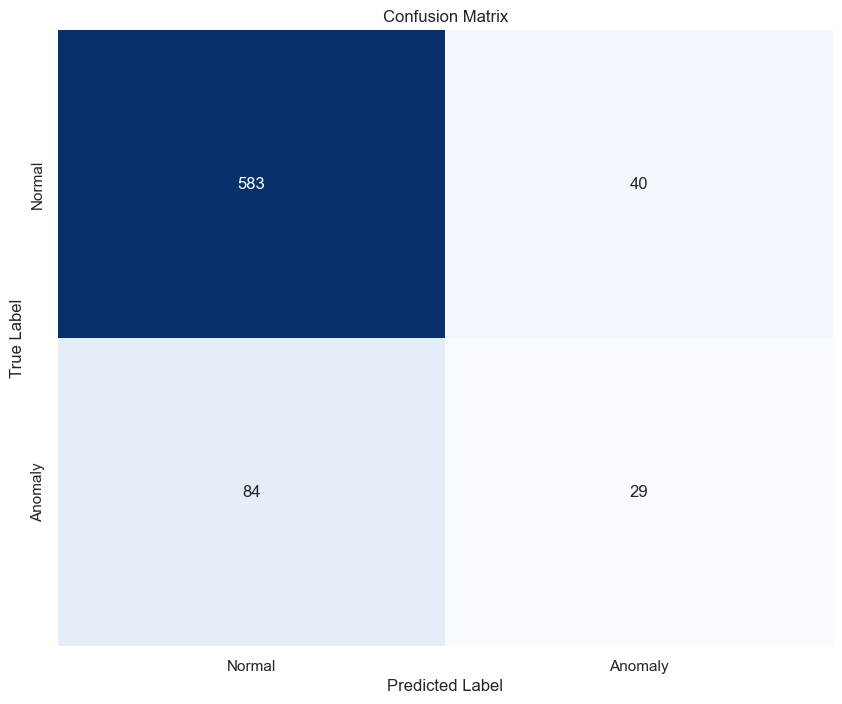

In [22]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

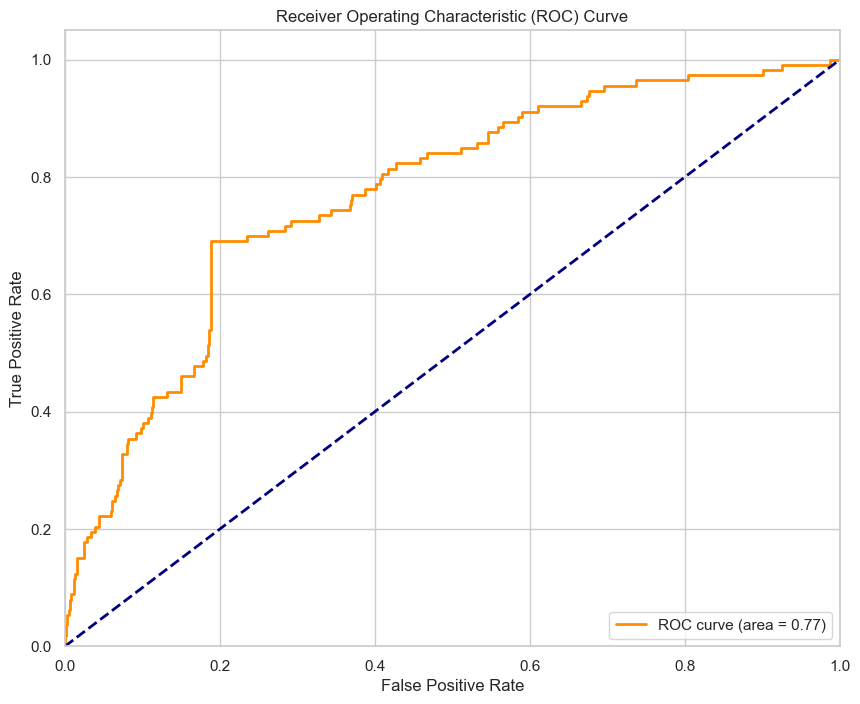

In [23]:
# Calculate and plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

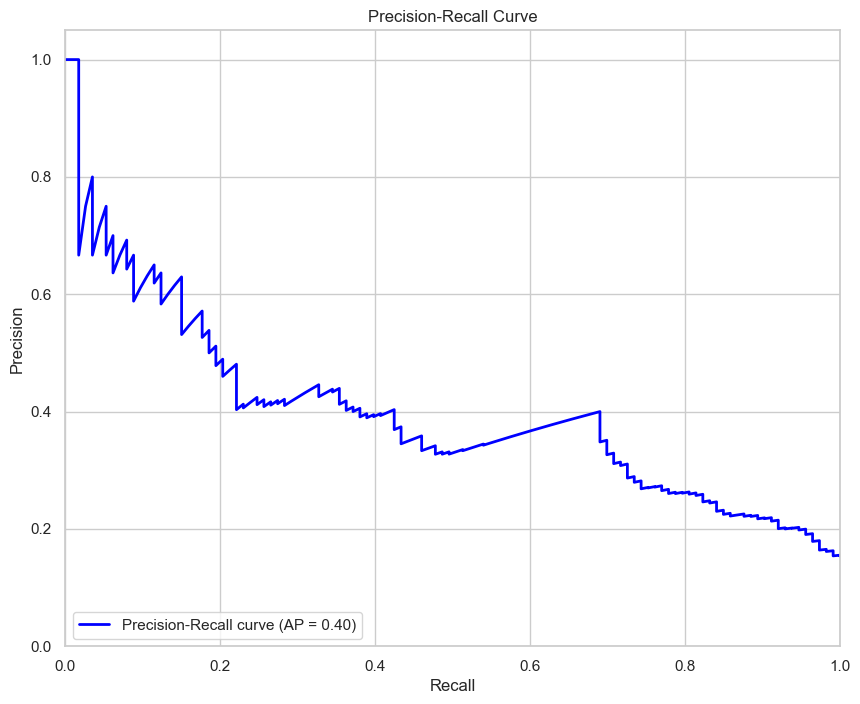

In [24]:
# Calculate and plot Precision-Recall curve
precision_values, recall_values, _ = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

plt.figure(figsize=(10, 8))
plt.plot(recall_values, precision_values, color='blue', lw=2, 
         label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

### 6. Visualizing Decision Boundaries

Explained variance ratio: [0.23624701 0.11015564]
Total explained variance: 0.35


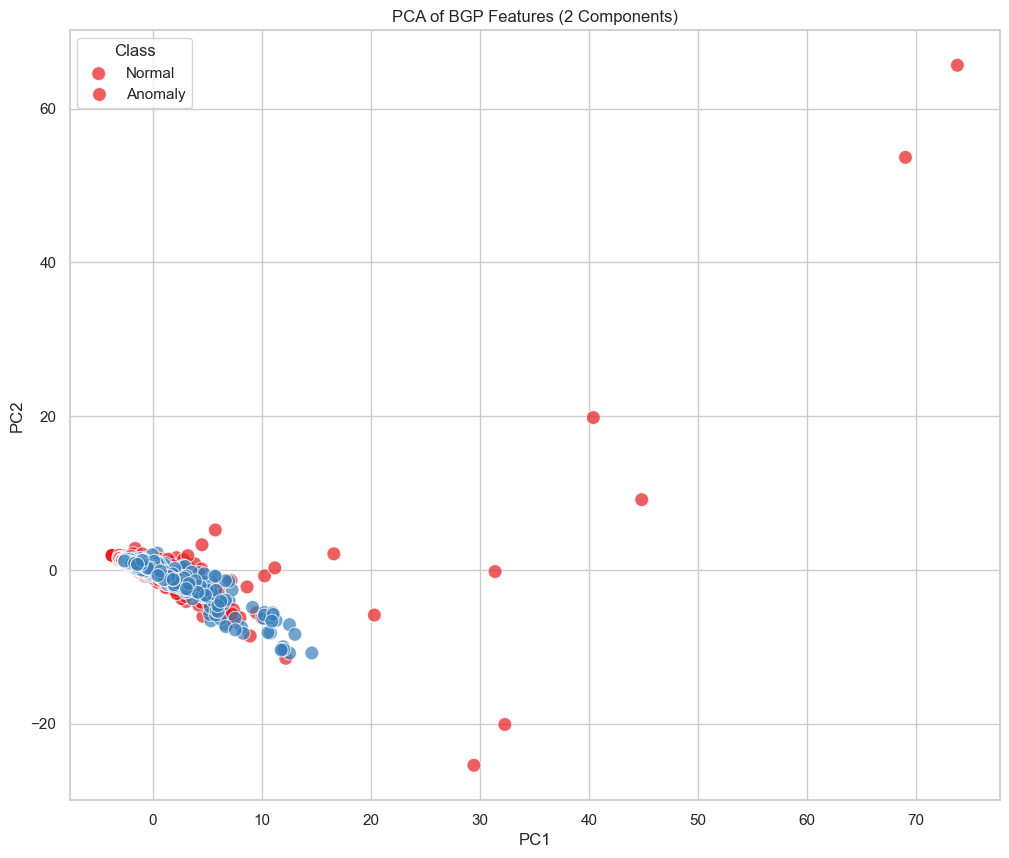

In [25]:
# Apply PCA to reduce to 2 dimensions for visualization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Explained variance
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.2f}")

# Create a DataFrame for easier plotting
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['class'] = y_train.values

# Plot PCA results
plt.figure(figsize=(12, 10))
sns.scatterplot(x='PC1', y='PC2', hue='class', data=pca_df, palette='Set1', s=100, alpha=0.7)
plt.title('PCA of BGP Features (2 Components)')
plt.legend(title='Class', labels=['Normal', 'Anomaly'])
plt.show()

<Figure size 1400x1200 with 0 Axes>

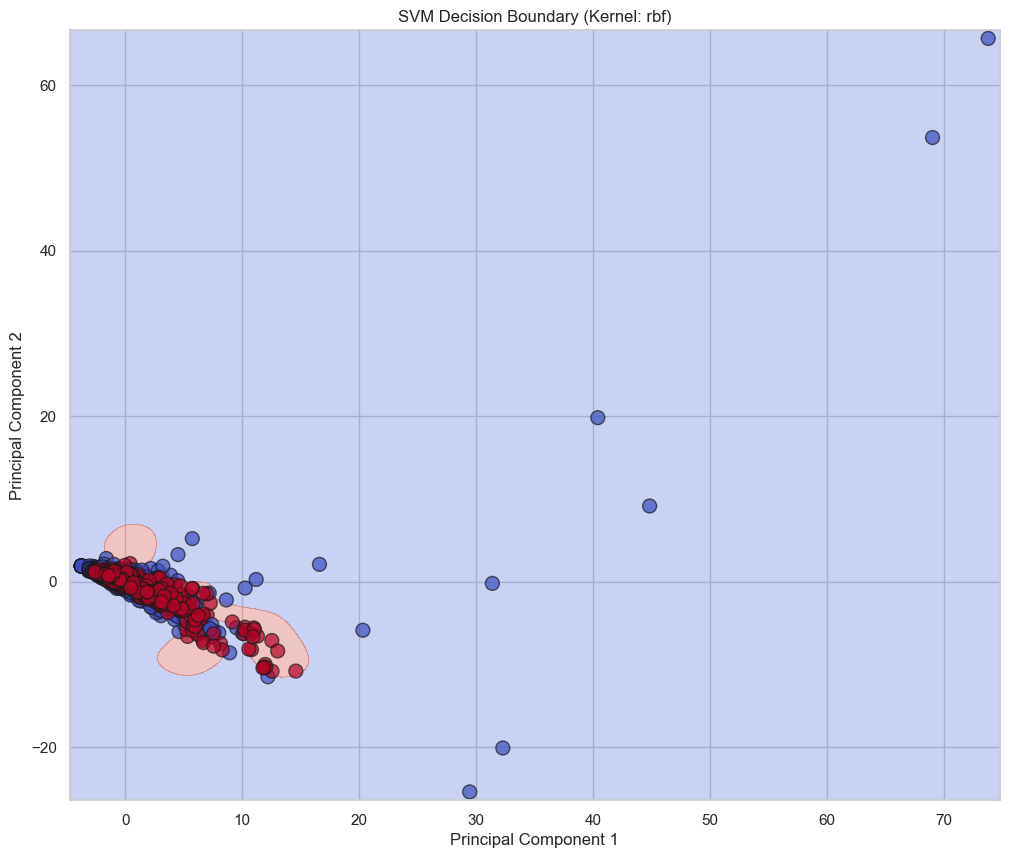

In [27]:
# Train an SVM on the PCA-transformed data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_test)
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_scaled)

X_train_pca = X_pca
y_train_pca = y_train

y_test_pca = y_test

# Use best parameters from grid search but adapt to the 2D case
# best_params = grid_search.best_params_
svm_2d = SVC(
    C=best_params['svm__C'],
    gamma=best_params['svm__gamma'] if best_params['svm__gamma'] not in ['scale', 'auto'] else 'scale',
    kernel=best_params['svm__kernel'],
    probability=True
)
svm_2d.fit(X_train_pca, y_train_pca)

# Plot decision boundary
def plot_decision_boundary(X, y, model, ax=None):
    h = 0.02  # Step size in the mesh
    
    # Create mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Get predictions for each point in the mesh
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot
    if ax is None:
        plt.figure(figsize=(12, 10))
        ax = plt.gca()
    
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=100, alpha=0.7, edgecolors='k')
    return ax

plt.figure(figsize=(14, 12))
ax = plot_decision_boundary(X_pca, y_train.values, svm_2d)
plt.title(f'SVM Decision Boundary (Kernel: {best_params["svm__kernel"]})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

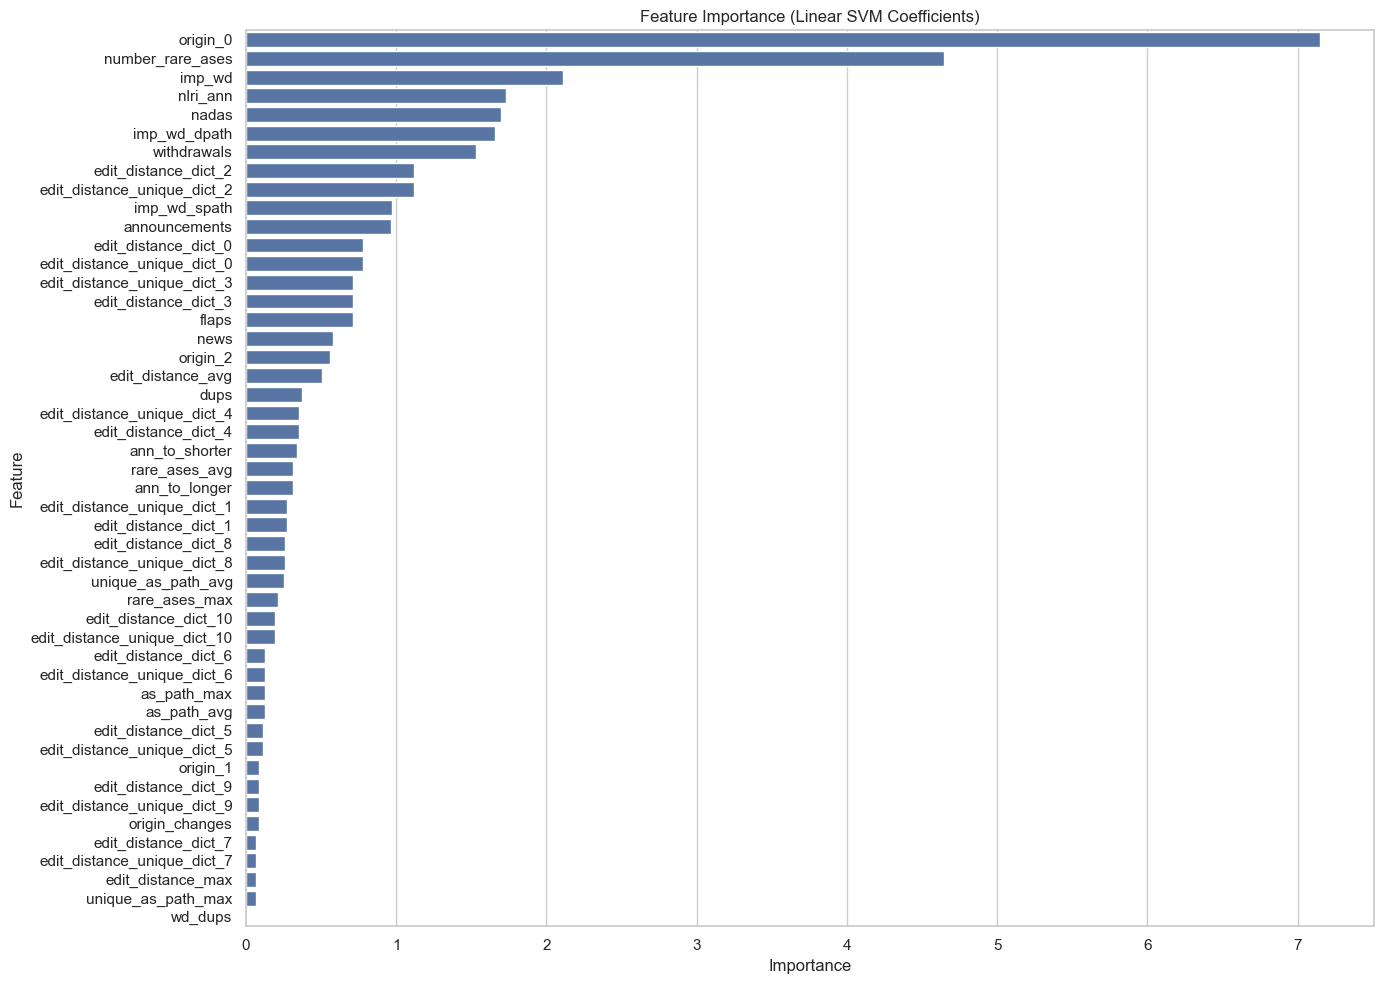

In [28]:
# Create and train a linear SVM for feature importance analysis
linear_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear'))
])
linear_svm.fit(X_train, y_train)

# Extract feature importance scores (coefficients)
importances = abs(linear_svm.named_steps['svm'].coef_[0])
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(14, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance (Linear SVM Coefficients)')
plt.tight_layout()
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

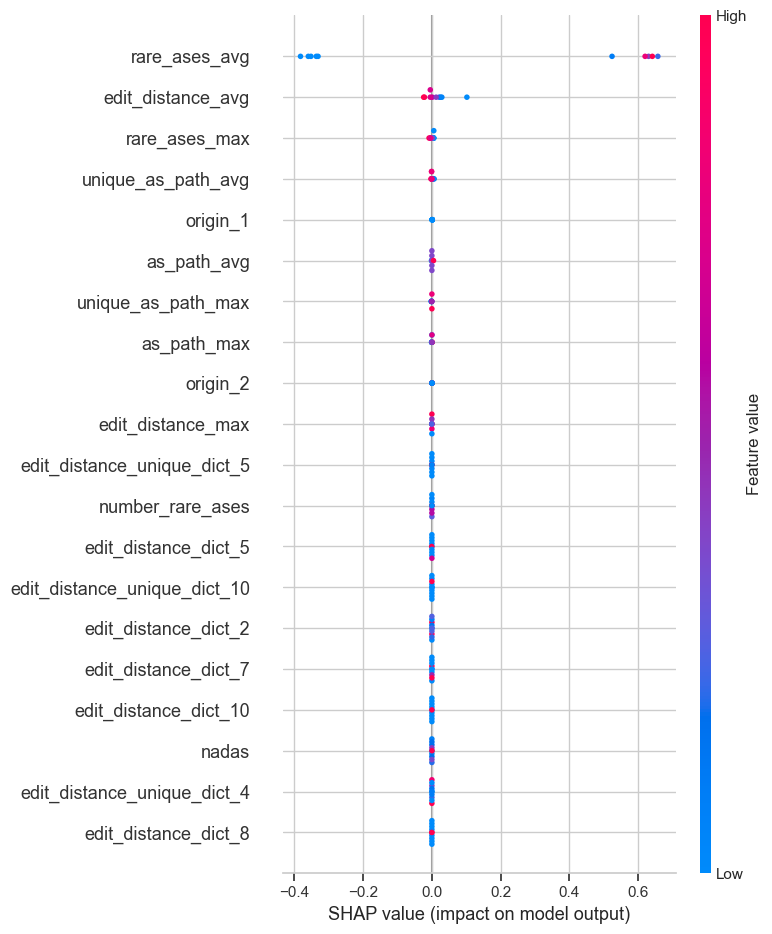

<Figure size 1200x800 with 0 Axes>

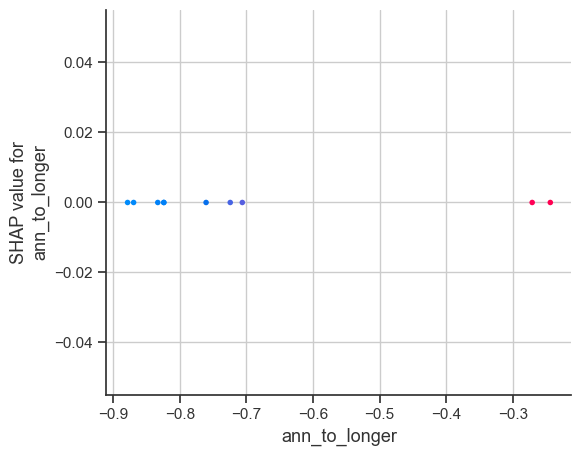

In [29]:
if EXPLAINABILITY_AVAILABLE:
    # Create a simpler model for SHAP analysis (to speed up computation)
    shap_model = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='linear', probability=True))
    ])
    shap_model.fit(X_train, y_train)
    
    # Use a subset of training data as background for the explainer
    X_train_sample = X_train.sample(min(100, len(X_train)), random_state=42)
    X_train_transformed = shap_model.named_steps['scaler'].transform(X_train_sample)
    
    # Create a SHAP KernelExplainer
    def f(x):
        return shap_model.predict_proba(x)[:,1]
    
    explainer = shap.KernelExplainer(f, X_train_transformed)
    
    # Select a sample of test instances to explain
    X_test_sample = X_test.sample(min(10, len(X_test)), random_state=42)
    X_test_transformed = shap_model.named_steps['scaler'].transform(X_test_sample)
    
    # Compute SHAP values
    shap_values = explainer.shap_values(X_test_transformed)
    
    # Summary plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_sample, feature_names=X.columns)
    
    # SHAP dependence plot for top feature
    top_feature_idx = np.argmax(np.abs(explainer.expected_value))
    top_feature = X_train.columns[top_feature_idx]
    
    plt.figure(figsize=(12, 8))
    shap.dependence_plot(top_feature_idx, shap_values, X_test_transformed, 
                         feature_names=X_train.columns)
else:
    print("SHAP analysis skipped because libraries are not installed.")

Intercept 0.16362765357665837
Prediction_local [0.03198911]
Right: 0.10464442391380256


<Figure size 1200x600 with 0 Axes>

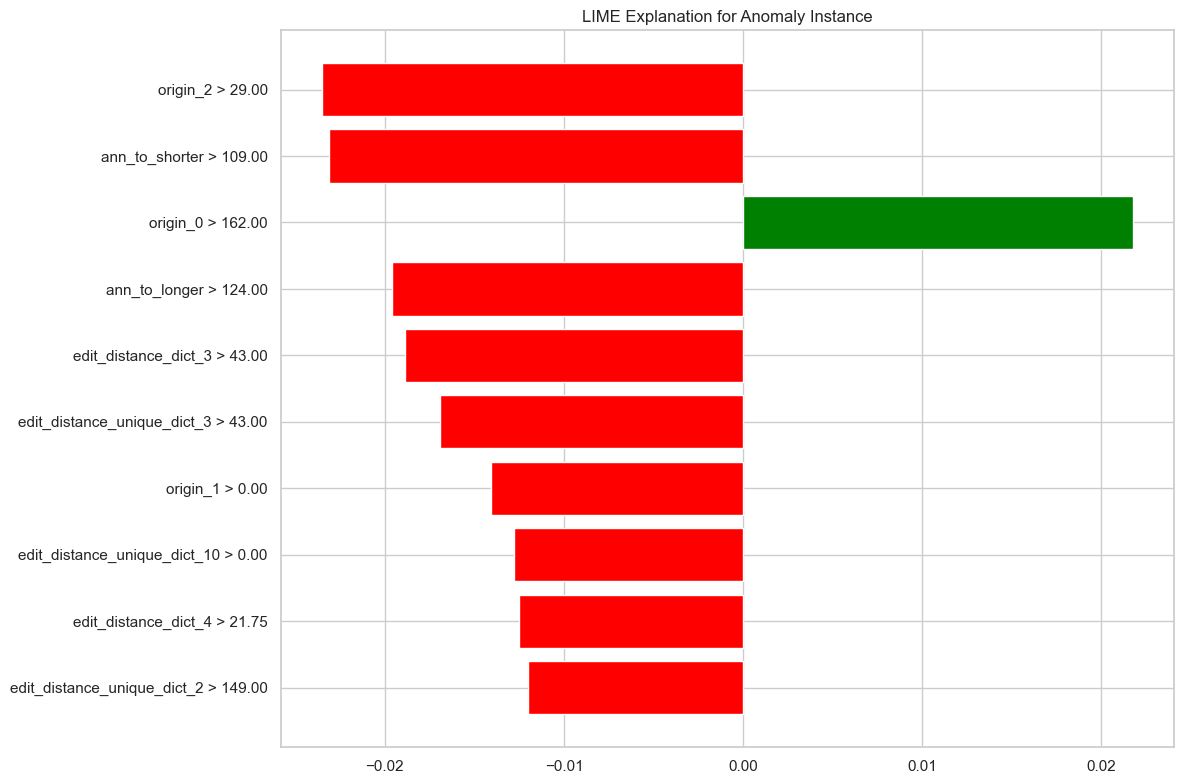

In [30]:
if EXPLAINABILITY_AVAILABLE:
    # Create a LIME explainer
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train.values,
        feature_names=X_train.columns.tolist(),
        class_names=['Normal', 'Anomaly'],
        verbose=True,
        mode='classification'
    )
    
    # Find an anomaly instance to explain
    anomaly_indices = np.where(y_test == 1)[0]
    if len(anomaly_indices) > 0:
        # Pick an anomaly in the test set
        anomaly_idx = anomaly_indices[0]
        anomaly_instance = X_test.iloc[anomaly_idx].values
        
        # Generate LIME explanation
        lime_exp = lime_explainer.explain_instance(
            anomaly_instance, 
            best_model.predict_proba,
            num_features=10
        )
        
        # Plot the explanation
        plt.figure(figsize=(12, 6))
        lime_exp.as_pyplot_figure()
        plt.title("LIME Explanation for Anomaly Instance")
        plt.tight_layout()
        plt.show()
    else:
        print("No anomalies found in test set")
else:
    print("LIME analysis skipped because libraries are not installed.")